## 0. Setup and Imports

In [1]:
import sys
import os

# Add project root to path if needed
project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import numpy as np
import torch
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
if device == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA A100-SXM4-40GB


In [2]:
# VDM-BIND imports
from config import PROJECT_ROOT, DATA_DIR, TRAIN_DATA_ROOT, QUANTILE_TRANSFORMER
from vdm.networks_clean import UNetVDM
from vdm.vdm_model_clean import LightCleanVDM
from vdm.astro_dataset import AstroDataset
from vdm.benchmark import BenchmarkSuite, quick_benchmark
from vdm.uncertainty import UncertaintyEstimator, compute_uncertainty_maps
from vdm.ensemble import ModelEnsemble

print(f"Project root: {PROJECT_ROOT}")
print(f"Data directory: {DATA_DIR}")
print(f"Training data: {TRAIN_DATA_ROOT}")
print(f"Quantile transformer: {QUANTILE_TRANSFORMER}")

Project root: /mnt/home/mlee1/vdm_BIND
Data directory: /mnt/home/mlee1/vdm_BIND/data
Training data: /mnt/home/mlee1/ceph/train_data_rotated2_128_cpu
Quantile transformer: /mnt/home/mlee1/vdm_BIND/data/quantile_normalizer_stellar.pkl


---
## 1. Load and Explore Training Data

First, let's load a subset of training data and understand its structure.

In [3]:
# =============================================================================
# TUTORIAL CONFIGURATION
# =============================================================================
# Choose your model type here!
# Available options: 'vdm', 'dsm', 'interpolant', 'stochastic_interpolant', 'ot_flow', 'consistency', 'dit'

MODEL_TYPE = 'dit'  # Change this to try different models!

# Model descriptions for reference:
MODEL_INFO = {
    'vdm': 'Variational Diffusion Model - Score-based diffusion with learned noise schedule',
    'dsm': 'Denoising Score Matching - Classic score-based model with NCSN++ style',
    'interpolant': 'Flow Matching - Deterministic ODE-based generation (fast sampling)',
    'stochastic_interpolant': 'Stochastic Interpolant - Flow matching with stochastic paths',
    'ot_flow': 'Optimal Transport Flow - OT-conditional flow matching',
    'consistency': 'Consistency Model - Direct mapping with consistency training',
    'dit': 'Diffusion Transformer - Transformer-based diffusion model (DiT architecture)',
}

print(f"Selected model: {MODEL_TYPE}")
print(f"Description: {MODEL_INFO.get(MODEL_TYPE, 'Unknown model type')}")
print()

# Training configuration
N_SAMPLES = 1000        # Number of training samples to use
BATCH_SIZE = 32         # Batch size for training
N_EPOCHS = 100            # Number of training epochs (small for demo)
IMAGE_SIZE = 128        # Image resolution
EMBEDDING_DIM = 32      # Reduced embedding dim for faster training
N_BLOCKS = 3            # Reduced blocks for faster training

Selected model: dit
Description: Diffusion Transformer - Transformer-based diffusion model (DiT architecture)



In [4]:
# Load normalization statistics
import joblib

dm_stats = np.load(DATA_DIR + '/dark_matter_normalization_stats.npz')
gas_stats = np.load(DATA_DIR + '/gas_normalization_stats.npz')
stellar_stats = np.load(DATA_DIR + '/stellar_normalization_stats.npz')

# Load quantile transformer for stellar channel (saved with joblib)
quantile_transformer = joblib.load(QUANTILE_TRANSFORMER)

print("Normalization Statistics:")
print(f"  DM: mean={dm_stats['dm_mag_mean']:.3f}, std={dm_stats['dm_mag_std']:.3f}")
print(f"  Gas: mean={gas_stats['gas_mag_mean']:.3f}, std={gas_stats['gas_mag_std']:.3f}")
print(f"  Stellar quantile transformer: {type(quantile_transformer).__name__}")

Normalization Statistics:
  DM: mean=9.915, std=0.468
  Gas: mean=9.177, std=0.411
  Stellar quantile transformer: QuantileTransformer


In [5]:
# Create dataset with limited samples
from torch.utils.data import DataLoader, Subset
import glob

# Find training files (use cached file list for speed)
train_dir = Path(TRAIN_DATA_ROOT) / 'train'
cache_file = train_dir / 'file_list_cache.txt'

if not train_dir.exists():
    print(f"Warning: Training data not found at {train_dir}")
    print("Using synthetic data for demonstration...")
    USE_SYNTHETIC = True
elif cache_file.exists():
    # Use cached file list (much faster than glob)
    with open(cache_file, 'r') as f:
        all_files = [line.strip() for line in f.readlines()]
    print(f"Loaded {len(all_files)} training files from cache")
    USE_SYNTHETIC = len(all_files) == 0
else:
    # Fall back to recursive glob (slow but works)
    print("Cache not found, scanning directories (this may take a while)...")
    all_files = sorted(glob.glob(str(train_dir / '**' / '*.npz'), recursive=True))
    print(f"Found {len(all_files)} training files")
    USE_SYNTHETIC = len(all_files) == 0

Loaded 408860 training files from cache


In [6]:
if USE_SYNTHETIC:
    # Create synthetic data for demonstration
    print("Creating synthetic demonstration data...")
    
    class SyntheticDataset(torch.utils.data.Dataset):
        """Synthetic dataset for testing when real data isn't available."""
        def __init__(self, n_samples, image_size=128, n_params=6):
            self.n_samples = n_samples
            self.image_size = image_size
            self.n_params = n_params
            
        def __len__(self):
            return self.n_samples
        
        def __getitem__(self, idx):
            # Generate correlated Gaussian random fields
            np.random.seed(idx)
            
            # Simple smoothed noise
            from scipy.ndimage import gaussian_filter
            
            dm = gaussian_filter(np.random.randn(self.image_size, self.image_size), sigma=5)
            dm_hydro = dm + 0.1 * gaussian_filter(np.random.randn(self.image_size, self.image_size), sigma=3)
            gas = 0.8 * dm + 0.2 * gaussian_filter(np.random.randn(self.image_size, self.image_size), sigma=4)
            # Stellar field - apply quantile transform to make it realistic
            star = 0.5 * dm + 0.5 * gaussian_filter(np.random.randn(self.image_size, self.image_size), sigma=2)
            
            return {
                'dm': torch.tensor(dm[None], dtype=torch.float32),
                'target': torch.tensor(np.stack([dm_hydro, gas, star]), dtype=torch.float32),
                'params': torch.zeros(self.n_params, dtype=torch.float32),
            }
    
    dataset = SyntheticDataset(N_SAMPLES)
    train_dataset = Subset(dataset, range(int(0.8 * N_SAMPLES)))
    val_dataset = Subset(dataset, range(int(0.8 * N_SAMPLES), N_SAMPLES))
else:
    # Use real data with proper normalization (including quantile for stellar)
    from vdm.astro_dataset import get_astro_data
    
    print(f"Loading data with quantile normalization for stellar channel...")
    
    # Use get_astro_data which handles all normalization properly
    # Note: dataset='IllustrisTNG' refers to the simulation type (for normalization constants)
    dm = get_astro_data(
        dataset='IllustrisTNG',  # Simulation type (not train/val split)
        data_root=str(TRAIN_DATA_ROOT),
        num_workers=4,
        batch_size=BATCH_SIZE,
        limit_train_samples=N_SAMPLES,
        limit_val_samples=int(N_SAMPLES * 0.2),
        quantile_path=QUANTILE_TRANSFORMER,  # Use quantile normalization for stellar
    )
    dm.setup()
    
    # AstroDataModule uses train_data/valid_data attributes (not train_dataset/val_dataset)
    train_dataset = dm.train_data
    val_dataset = dm.valid_data

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Loading data with quantile normalization for stellar channel...
✓ Loaded DM stats: mean=9.915499, std=0.467967
✓ Loaded Gas stats: mean=9.177344, std=0.410510
✓ Loading quantile transformer from: /mnt/home/mlee1/vdm_BIND/data/quantile_normalizer_stellar.pkl
  Quantile transformer loaded (n_quantiles=10000)
  Output distribution: uniform

📊 NORMALIZATION CONFIG (3-channel mode):
  DM input: mean=9.9777, std=0.4139
  DM target: mean=9.9155, std=0.4680
  Gas target: mean=9.1773, std=0.4105
  Stars target: QUANTILE TRANSFORMATION (n_quantiles=10000)
✓ Loaded DM stats: mean=9.915499, std=0.467967
✓ Loaded Gas stats: mean=9.177344, std=0.410510
✓ Loading quantile transformer from: /mnt/home/mlee1/vdm_BIND/data/quantile_normalizer_stellar.pkl
  Quantile transformer loaded (n_quantiles=10000)
  Output distribution: uniform

📊 NORMALIZATION CONFIG (3-channel mode):
  DM input: mean=9.9777, std=0.4139
  DM target: mean=9.9155, std=0.4680
  Gas target: mean=9.1773, std=0.4105
  Stars target: QUAN

In [7]:
# Create data loaders
if USE_SYNTHETIC:
    train_loader = DataLoader(
        train_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=True, 
        num_workers=4,
        pin_memory=True,
    )

    val_loader = DataLoader(
        val_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=False, 
        num_workers=4,
        pin_memory=True,
    )
else:
    # Use the data loaders from the DataModule
    train_loader = dm.train_dataloader()
    val_loader = dm.val_dataloader()

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

Training batches: 25
Validation batches: 7


Sample format: tuple with 4 elements
Large scale shape: torch.Size([32, 3, 128, 128])
Condition shape: torch.Size([32, 1, 128, 128])
Target shape: torch.Size([32, 3, 128, 128])
Params shape: torch.Size([32, 35])


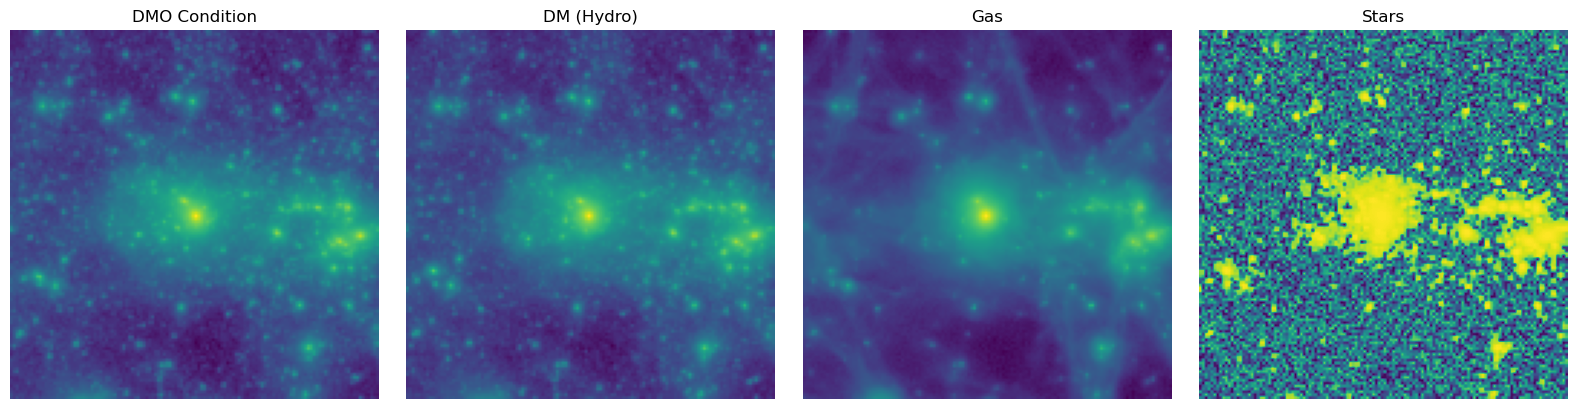

In [8]:
# Visualize a sample
sample = next(iter(train_loader))

# Handle different data formats: dict (synthetic) vs tuple (real AstroDataset)
if isinstance(sample, dict):
    # Synthetic dataset returns dict with keys: 'dm', 'target', 'params'
    condition = sample['dm']
    target = sample['target']
    params = sample['params']
    print(f"Sample format: dict with keys {sample.keys()}")
else:
    # Real AstroDataset returns tuple: (dm, large_scale, target, params)
    condition, large_scale, target, params = sample
    print(f"Sample format: tuple with {len(sample)} elements")
    print(f"Large scale shape: {large_scale.shape}")

print(f"Condition shape: {condition.shape}")
print(f"Target shape: {target.shape}")
print(f"Params shape: {params.shape}")

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
channel_names = ['DMO Condition', 'DM (Hydro)', 'Gas', 'Stars']

# Plot condition
axes[0].imshow(condition[0, 0].numpy(), cmap='viridis')
axes[0].set_title(channel_names[0])
axes[0].axis('off')

# Plot targets
for i in range(3):
    axes[i+1].imshow(target[0, i].numpy(), cmap='viridis')
    axes[i+1].set_title(channel_names[i+1])
    axes[i+1].axis('off')

plt.tight_layout()
plt.show()

---
## 2. Train a Model

Now let's train a small VDM model on our subset of data. We use a smaller architecture for faster training in this tutorial.

In [9]:
# Create the score model (UNet architecture) - shared by all model types
# Note: Real data includes large_scale conditioning (3 channels), synthetic does not
LARGE_SCALE_CHANNELS = 0 if USE_SYNTHETIC else 3

score_model = UNetVDM(
    input_channels=3,           # Output: DM, Gas, Stars
    gamma_min=-13.3,            # Min log-SNR (used by VDM/DSM)
    gamma_max=13.0,              # Max log-SNR
    embedding_dim=EMBEDDING_DIM, # Reduced for tutorial
    n_blocks=N_BLOCKS,          # Reduced for tutorial
    n_attention_heads=4,
    norm_groups=8,
    add_attention=True,
    use_fourier_features=True,
    conditioning_channels=1,    # DMO condition
    large_scale_channels=LARGE_SCALE_CHANNELS,  # Multi-scale context (3 for real data)
)

# Count parameters
n_params = sum(p.numel() for p in score_model.parameters())
print(f"Score model (UNet) parameters: {n_params:,}")
print(f"Large scale channels: {LARGE_SCALE_CHANNELS}")

✓ Scale-appropriate Fourier features enabled:
  - Halo (m_dm): High frequencies [1, 2, 4, 8]π -> 8 features per channel
  - Large-scale: Low frequencies [0.25, 0.5, 1, 2]π -> 8 features per channel
  - Target: No Fourier features (learns naturally)
  - Total input channels: 39
✓ Channel progression (encoder): [32, 64, 128]
✓ Final decoder channels: 32 (GroupNorm groups: 8)
Score model (UNet) parameters: 3,706,115
Large scale channels: 3
✓ Final decoder channels: 32 (GroupNorm groups: 8)
Score model (UNet) parameters: 3,706,115
Large scale channels: 3


In [10]:
# Create the Lightning model based on MODEL_TYPE selection
# Each model uses the same UNet backbone but different training objectives

if MODEL_TYPE == 'vdm':
    # Variational Diffusion Model
    model = LightCleanVDM(
        score_model=score_model,
        learning_rate=1e-4,
        gamma_min=-13.3,
        gamma_max=5.0,
        image_shape=(3, IMAGE_SIZE, IMAGE_SIZE),
        noise_schedule='fixed_linear',
        channel_weights=[1.0, 1.0, 1.0],
        antithetic_time_sampling=True,
    )
    monitor_metric = 'val/elbo'
    
elif MODEL_TYPE == 'dsm':
    # Denoising Score Matching
    from vdm.dsm_model import LightDSM
    model = LightDSM(
        score_model=score_model,
        beta_min=0.1,
        beta_max=20.0,
        learning_rate=1e-4,
        weight_decay=1e-5,
        lr_scheduler='cosine',
        n_sampling_steps=250,
        use_snr_weighting=True,
        channel_weights=[1.0, 1.0, 1.0],
    )
    monitor_metric = 'val/loss'
    
elif MODEL_TYPE in ['interpolant', 'stochastic_interpolant']:
    # Flow Matching / Stochastic Interpolant
    from vdm.interpolant_model import LightInterpolant, VelocityNetWrapper
    
    total_cond_channels = 1 + LARGE_SCALE_CHANNELS
    velocity_model = VelocityNetWrapper(
        net=score_model,
        output_channels=3,
        conditioning_channels=total_cond_channels,
    )
    
    model = LightInterpolant(
        velocity_model=velocity_model,
        learning_rate=1e-4,
        weight_decay=1e-5,
        lr_scheduler='cosine',
        n_sampling_steps=50,  # Flow models need fewer steps!
        use_stochastic_interpolant=(MODEL_TYPE == 'stochastic_interpolant'),
        sigma=0.1 if MODEL_TYPE == 'stochastic_interpolant' else 0.0,
        x0_mode='zeros',
    )
    monitor_metric = 'val/loss'
    
elif MODEL_TYPE == 'ot_flow':
    # Optimal Transport Flow Matching
    from vdm.ot_flow_model import LightOTFlow, OTVelocityNetWrapper
    
    total_cond_channels = 1 + LARGE_SCALE_CHANNELS
    velocity_model = OTVelocityNetWrapper(
        net=score_model,
        output_channels=3,
        conditioning_channels=total_cond_channels,
    )
    
    model = LightOTFlow(
        velocity_model=velocity_model,
        learning_rate=1e-4,
        weight_decay=1e-5,
        lr_scheduler='cosine',
        n_sampling_steps=50,
    )
    monitor_metric = 'val/loss'
    
elif MODEL_TYPE == 'consistency':
    # Consistency Model
    from vdm.consistency_model import LightConsistency
    model = LightConsistency(
        score_model=score_model,
        learning_rate=1e-4,
        weight_decay=1e-5,
        sigma_min=0.002,
        sigma_max=80.0,
        rho=7.0,
        n_sampling_steps=1,  # Consistency models can generate in 1-2 steps!
        channel_weights=[1.0, 1.0, 1.0],
    )
    monitor_metric = 'val/loss'

elif MODEL_TYPE == 'dit':
    # Diffusion Transformer (DiT) - uses its own architecture, not UNet
    from vdm.dit import DiT
    from vdm.dit_model import LightDiTVDM
    
    # DiT has its own architecture - smaller variant for tutorial
    total_cond_channels = 1 + LARGE_SCALE_CHANNELS
    dit_model = DiT(
        img_size=IMAGE_SIZE,
        patch_size=8,           # Larger patches = faster training
        hidden_size=256,        # Smaller for tutorial (DiT-S uses 384)
        depth=6,                # Fewer layers for tutorial (DiT-S uses 12)
        num_heads=4,
        mlp_ratio=4.0,
        n_params=6 if USE_SYNTHETIC else 35,  # Cosmological params
        conditioning_channels=1,
        large_scale_channels=LARGE_SCALE_CHANNELS,
    )
    
    model = LightDiTVDM(
        dit_model=dit_model,
        learning_rate=1e-4,
        gamma_min=-13.3,
        gamma_max=13.0,
        n_sampling_steps=50,    # Fewer steps for faster sampling
        image_shape=(3, IMAGE_SIZE, IMAGE_SIZE),
    )
    # DiT doesn't use the UNet score_model, so delete it to save memory
    del score_model
    monitor_metric = 'val/loss'
    
else:
    raise ValueError(f"Unknown MODEL_TYPE: {MODEL_TYPE}. Choose from: {list(MODEL_INFO.keys())}")

print(f"Created {MODEL_TYPE.upper()} model with {sum(p.numel() for p in model.parameters()):,} parameters")
print(f"Monitor metric: {monitor_metric}")


INITIALIZED DiT MODEL
  Image size: 128x128
  Patch size: 8
  Num patches: 256
  Hidden size: 256
  Depth: 6
  Heads: 4
  MLP ratio: 4.0
  Parameters: 35 (0=unconditional)
  Conditioning: 1 + 3 large-scale
  Total params: 7,603,392


INITIALIZED LightDiTVDM
  Learning rate: 0.0001
  Gamma range: [-13.3, 13.0]
  Sampling steps: 50
  Loss type: mse
  Image shape: (3, 128, 128)

Created DIT model with 7,603,392 parameters
Monitor metric: val/loss


In [11]:
# Set up PyTorch Lightning trainer
# Use 'lightning' (new package name) instead of 'pytorch_lightning' (legacy)
import lightning as pl
from lightning.pytorch.callbacks import ModelCheckpoint, TQDMProgressBar

# Create checkpoint directory
ckpt_dir = Path(project_root) / 'analysis' / 'notebooks' / 'tutorial_checkpoints'
ckpt_dir.mkdir(exist_ok=True)

# Callbacks - use monitor_metric from model creation cell
# VDM uses 'val/elbo' (maximize), others use 'val/loss' (minimize)
checkpoint_callback = ModelCheckpoint(
    dirpath=str(ckpt_dir),
    filename=f'tutorial-{MODEL_TYPE}' + '-{epoch:02d}',
    save_top_k=1,
    monitor=monitor_metric,
    mode='max' if 'elbo' in monitor_metric else 'min',
)

# Create trainer
trainer = pl.Trainer(
    max_epochs=N_EPOCHS,
    accelerator='gpu' if device == 'cuda' else 'cpu',
    devices=1,
    callbacks=[checkpoint_callback, TQDMProgressBar(refresh_rate=10)],
    enable_progress_bar=True,
    log_every_n_steps=10,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [12]:
# Train the model
print("Starting training...")
print(f"  Epochs: {N_EPOCHS}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Training samples: {len(train_dataset)}")

trainer.fit(model, train_loader, val_loader)

You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Starting training...
  Epochs: 100
  Batch size: 32
  Training samples: 800


2025-12-15 18:32:22.292793: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-15 18:32:22.823850: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type | Params | Mode 
---------------------------------------------
0 | score_model | DiT  | 7.6 M  | train
---------------------------------------------
7.6 M     Trainable params
0         Non-trainable params
7.6 M     Total params
30.414    Total estimated model params size (

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [14]:
# Check training results
print(f"\nTraining complete!")
print(f"Model type: {MODEL_TYPE}")
print(f"Best checkpoint: {checkpoint_callback.best_model_path}")
print(f"Best {monitor_metric}: {checkpoint_callback.best_model_score:.4f}")


Training complete!
Model type: dit
Best checkpoint: /mnt/home/mlee1/vdm_BIND/analysis/notebooks/tutorial_checkpoints/tutorial-dit-epoch=99.ckpt
Best val/loss: 0.3465


---
## 3. Generate Samples

Now let's use the trained model to generate baryonic fields from DMO conditions.

In [15]:
# Load the best checkpoint (model-type specific)
best_ckpt = checkpoint_callback.best_model_path

if best_ckpt:
    # Load checkpoint based on model type
    if MODEL_TYPE == 'vdm':
        model = LightCleanVDM.load_from_checkpoint(best_ckpt, score_model=score_model)
    elif MODEL_TYPE == 'dsm':
        from vdm.dsm_model import LightDSM
        model = LightDSM.load_from_checkpoint(best_ckpt, score_model=score_model)
    elif MODEL_TYPE in ['interpolant', 'stochastic_interpolant']:
        from vdm.interpolant_model import LightInterpolant, VelocityNetWrapper
        total_cond_channels = 1 + LARGE_SCALE_CHANNELS
        velocity_model = VelocityNetWrapper(net=score_model, output_channels=3, 
                                            conditioning_channels=total_cond_channels)
        model = LightInterpolant.load_from_checkpoint(best_ckpt, velocity_model=velocity_model)
    elif MODEL_TYPE == 'ot_flow':
        from vdm.ot_flow_model import LightOTFlow, OTVelocityNetWrapper
        total_cond_channels = 1 + LARGE_SCALE_CHANNELS
        velocity_model = OTVelocityNetWrapper(net=score_model, output_channels=3,
                                               conditioning_channels=total_cond_channels)
        model = LightOTFlow.load_from_checkpoint(best_ckpt, velocity_model=velocity_model)
    elif MODEL_TYPE == 'consistency':
        from vdm.consistency_model import LightConsistency
        model = LightConsistency.load_from_checkpoint(best_ckpt, score_model=score_model)
    
    print(f"Loaded {MODEL_TYPE} checkpoint: {best_ckpt}")

model = model.to(device)
model.eval()

Loaded dit checkpoint: /mnt/home/mlee1/vdm_BIND/analysis/notebooks/tutorial_checkpoints/tutorial-dit-epoch=99.ckpt


LightDiTVDM(
  (score_model): DiT(
    (x_embedder): PatchEmbed(
      (proj): Conv2d(7, 256, kernel_size=(8, 8), stride=(8, 8))
    )
    (t_embedder): TimestepEmbedder(
      (mlp): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): SiLU()
        (2): Linear(in_features=256, out_features=256, bias=True)
      )
    )
    (y_embedder): ParamEmbedder(
      (mlp): Sequential(
        (0): Linear(in_features=35, out_features=256, bias=True)
        (1): SiLU()
        (2): Linear(in_features=256, out_features=256, bias=True)
      )
    )
    (blocks): ModuleList(
      (0-5): 6 x DiTBlock(
        (norm1): LayerNorm((256,), eps=1e-06, elementwise_affine=False)
        (attn): Attention(
          (qkv): Linear(in_features=256, out_features=768, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=256, out_features=256, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
      

In [16]:
# Get a validation batch for generation
val_batch = next(iter(val_loader))

# Handle different data formats
if isinstance(val_batch, dict):
    # Synthetic data - no large_scale
    condition = val_batch['dm'].to(device)
    params = val_batch['params'].to(device)
    target = val_batch['target'].to(device)
    # For sampling, conditioning is just dm
    full_conditioning = condition
else:
    # Real AstroDataset returns tuple: (dm, large_scale, target, params)
    dm_cond, large_scale, target, params = val_batch
    dm_cond = dm_cond.to(device)
    large_scale = large_scale.to(device)
    params = params.to(device)
    target = target.to(device)
    # For sampling, conditioning must include large_scale (like in training)
    full_conditioning = torch.cat([dm_cond, large_scale], dim=1)
    condition = dm_cond  # Keep for visualization

print(f"Full conditioning shape: {full_conditioning.shape}")
print(f"Params shape: {params.shape}")

Full conditioning shape: torch.Size([32, 4, 128, 128])
Params shape: torch.Size([32, 35])


In [17]:
# Generate samples
# Number of sampling steps depends on model type:
# - VDM/DSM: 250-500 steps (diffusion-based)
# - Interpolant/OT-Flow: 50-100 steps (flow-based, much faster!)
# - Consistency: 1-2 steps (direct mapping, very fast!)

SAMPLING_STEPS = {
    'vdm': 250,
    'dsm': 250,
    'interpolant': 50,
    'stochastic_interpolant': 50,
    'ot_flow': 50,
    'consistency': 2,
    'dit':500
}
n_steps = SAMPLING_STEPS.get(MODEL_TYPE, 100)

print(f"Generating samples with {MODEL_TYPE} ({n_steps} steps)...")
with torch.no_grad():
    single_sample = model.draw_samples(
        conditioning=full_conditioning[:4],
        batch_size=4,
        n_sampling_steps=n_steps,
        param_conditioning=params[:4],
    )
    
print(f"Generated sample shape: {single_sample.shape}")

Generating samples with dit (500 steps)...
Generated sample shape: torch.Size([4, 3, 128, 128])
Generated sample shape: torch.Size([4, 3, 128, 128])


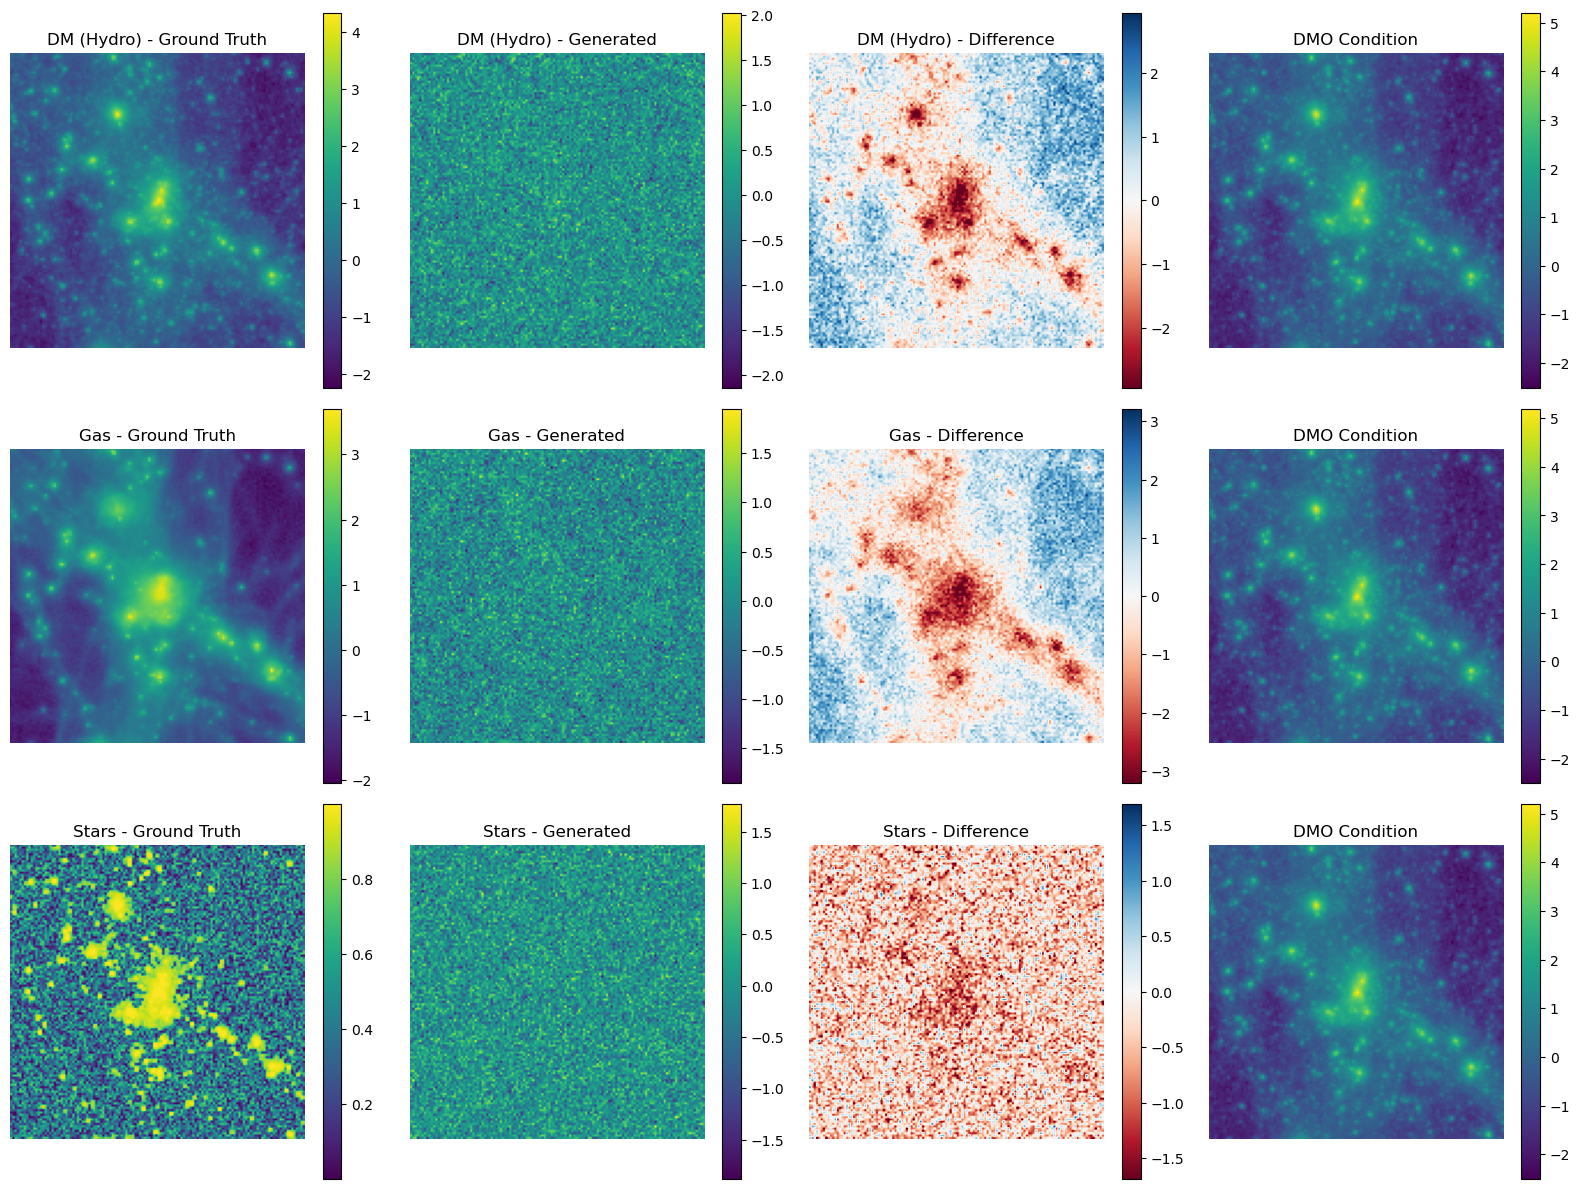

In [18]:
# Visualize generated vs ground truth
fig, axes = plt.subplots(3, 4, figsize=(16, 12))

sample_idx = 0
channel_names = ['DM (Hydro)', 'Gas', 'Stars']

for row, (name, ch) in enumerate(zip(channel_names, range(3))):
    # Ground truth
    im1 = axes[row, 0].imshow(target[sample_idx, ch].cpu().numpy(), cmap='viridis')
    axes[row, 0].set_title(f'{name} - Ground Truth')
    axes[row, 0].axis('off')
    plt.colorbar(im1, ax=axes[row, 0])
    
    # Generated
    im2 = axes[row, 1].imshow(single_sample[sample_idx, ch].cpu().numpy(), cmap='viridis')
    axes[row, 1].set_title(f'{name} - Generated')
    axes[row, 1].axis('off')
    plt.colorbar(im2, ax=axes[row, 1])
    
    # Difference
    diff = single_sample[sample_idx, ch].cpu().numpy() - target[sample_idx, ch].cpu().numpy()
    im3 = axes[row, 2].imshow(diff, cmap='RdBu', vmin=-diff.std()*3, vmax=diff.std()*3)
    axes[row, 2].set_title(f'{name} - Difference')
    axes[row, 2].axis('off')
    plt.colorbar(im3, ax=axes[row, 2])
    
    # Condition
    im4 = axes[row, 3].imshow(condition[sample_idx, 0].cpu().numpy(), cmap='viridis')
    axes[row, 3].set_title('DMO Condition')
    axes[row, 3].axis('off')
    plt.colorbar(im4, ax=axes[row, 3])

plt.tight_layout()
plt.savefig('generated_samples.png', dpi=150, bbox_inches='tight')
plt.show()

In [19]:
# Debug: Check sample statistics
print("Sample statistics:")
print(f"  single_sample shape: {single_sample.shape}")
print(f"  single_sample min: {single_sample.min():.4f}")
print(f"  single_sample max: {single_sample.max():.4f}")
print(f"  single_sample std: {single_sample.std():.4f}")
print(f"  single_sample mean: {single_sample.mean():.4f}")

print("\nTarget statistics:")
print(f"  target min: {target.min():.4f}")
print(f"  target max: {target.max():.4f}")
print(f"  target std: {target.std():.4f}")
print(f"  target mean: {target.mean():.4f}")

# Check if output looks like noise (std close to 1, mean close to 0)
if abs(single_sample.std() - 1.0) < 0.3 and abs(single_sample.mean()) < 0.3:
    print("\n⚠️ WARNING: Sample looks like standard normal noise!")
    print("This suggests the model may not be denoising properly.")

Sample statistics:
  single_sample shape: torch.Size([4, 3, 128, 128])
  single_sample min: -2.5396
  single_sample max: 2.2177
  single_sample std: 0.5085
  single_sample mean: 0.0041

Target statistics:
  target min: -3.1086
  target max: 5.6940
  target std: 0.8209
  target mean: 0.1564


In [20]:
# Deep debug: trace through one sampling step
model.eval()
model = model.to(device)

# Get test conditioning
test_cond = full_conditioning[:1].to(device)
test_params = params[:1].to(device)

# Manually trace sampling
B = 1
n_steps = 50

# Start from noise
z = torch.randn(B, 3, 128, 128, device=device)
print(f"Initial z: min={z.min():.3f}, max={z.max():.3f}, std={z.std():.3f}")

# Get gamma at t=1.0 and t=0.0
gamma_1 = model.gamma(torch.tensor([1.0], device=device))
gamma_0 = model.gamma(torch.tensor([0.0], device=device))
print(f"\ngamma(t=1.0) = {gamma_1.item():.3f}  (should be ~13.0 for noisy)")
print(f"gamma(t=0.0) = {gamma_0.item():.3f}  (should be ~-13.3 for clean)")

# Check sigma and alpha at extremes
sigma_1, alpha_1 = model.sigma_and_alpha(gamma_1)
sigma_0, alpha_0 = model.sigma_and_alpha(gamma_0)
print(f"\nAt t=1.0 (noisy): sigma={sigma_1.item():.4f}, alpha={alpha_1.item():.4f}")
print(f"At t=0.0 (clean): sigma={sigma_0.item():.4f}, alpha={alpha_0.item():.4f}")

# Check noise prediction at t=1
with torch.no_grad():
    eps_pred = model.score_model(z, gamma_1.expand(B), test_cond, test_params)
print(f"\nNoise prediction at t=1: min={eps_pred.min():.3f}, max={eps_pred.max():.3f}, std={eps_pred.std():.3f}")

# Check c coefficient
gamma_t = gamma_1
gamma_s = model.gamma(torch.tensor([0.98], device=device))  # s close to t
c = -torch.expm1(gamma_s - gamma_t)
print(f"\nc coefficient (from t=1.0 to s=0.98): {c.item():.4f}")
print(f"  gamma_t = {gamma_t.item():.3f}")
print(f"  gamma_s = {gamma_s.item():.3f}")
print(f"  gamma_s - gamma_t = {(gamma_s - gamma_t).item():.4f}")

# The issue: if gamma increases with t (VDM convention), then gamma_s < gamma_t
# So gamma_s - gamma_t < 0, and c = 1 - exp(negative) which is positive
# But if gamma_s > gamma_t, then c would be negative which would break sqrt(c)

Initial z: min=-4.135, max=4.904, std=0.999

gamma(t=1.0) = 13.000  (should be ~13.0 for noisy)
gamma(t=0.0) = -13.300  (should be ~-13.3 for clean)

At t=1.0 (noisy): sigma=0.0015, alpha=1.0000
At t=0.0 (clean): sigma=1.0000, alpha=0.0013

Noise prediction at t=1: min=-0.865, max=0.895, std=0.196

c coefficient (from t=1.0 to s=0.98): 0.4090
  gamma_t = 13.000
  gamma_s = 12.474
  gamma_s - gamma_t = -0.5260


In [21]:
# Compare with VDM model's gamma convention
# Load the VDM model and check its gamma schedule
from vdm.vdm_model_clean import LightCleanVDM
from vdm.utils import FixedLinearSchedule

# Create a test schedule with same parameters
vdm_gamma = FixedLinearSchedule(gamma_min=-13.3, gamma_max=5.0)

print("VDM FixedLinearSchedule:")
t_vals = torch.tensor([0.0, 0.5, 1.0])
for t in t_vals:
    g = vdm_gamma(t)
    print(f"  t={t.item():.1f}: gamma={g.item():.2f}")

print("\nDiT gamma (after my change):")
for t in t_vals:
    g = model.gamma(t.unsqueeze(0))
    print(f"  t={t.item():.1f}: gamma={g.item():.2f}")
    
# Check alpha/sigma
print("\nDiT alpha/sigma:")
for t in t_vals:
    g = model.gamma(t.unsqueeze(0).to(device))
    sigma, alpha = model.sigma_and_alpha(g)
    print(f"  t={t.item():.1f}: gamma={g.item():.2f}, alpha={alpha.item():.4f}, sigma={sigma.item():.4f}")

VDM FixedLinearSchedule:
  t=0.0: gamma=-13.30
  t=0.5: gamma=-4.15
  t=1.0: gamma=5.00

DiT gamma (after my change):
  t=0.0: gamma=-13.30
  t=0.5: gamma=-0.15
  t=1.0: gamma=13.00

DiT alpha/sigma:
  t=0.0: gamma=-13.30, alpha=0.0013, sigma=1.0000
  t=0.5: gamma=-0.15, alpha=0.6801, sigma=0.7331
  t=1.0: gamma=13.00, alpha=1.0000, sigma=0.0015


In [23]:
# Test VDM sampling to understand the convention
# Load a working VDM model and trace through sampling
from bind.workflow_utils import ConfigLoader, ModelManager

vdm_config = ConfigLoader('/mnt/home/mlee1/vdm_BIND/configs/clean_vdm_aggressive_stellar.ini')
_, vdm_model = ModelManager.initialize(vdm_config, verbose=False, skip_data_loading=True)
vdm_model = vdm_model.to(device).eval()

# Check VDM gamma at different t values
print("VDM model gamma:")
for t_val in [0.0, 0.5, 1.0]:
    t = torch.tensor([[[[t_val]]]], device=device)
    g = vdm_model.model.gamma(t)
    alpha = vdm_model.model.alpha(g)
    sigma = vdm_model.model.sigma(g)
    print(f"  t={t_val}: gamma={g.item():.2f}, alpha={alpha.item():.4f}, sigma={sigma.item():.4f}")

# Check what z_t looks like at different times
x = target[:1].to(device)  # Clean data
print(f"\nClean data x: min={x.min():.3f}, max={x.max():.3f}, std={x.std():.3f}")

for t_val in [0.0, 0.5, 1.0]:
    t = torch.tensor([t_val], device=device)
    gamma_t = vdm_model.model.gamma(t.view(1,1,1,1))
    alpha_t = vdm_model.model.alpha(gamma_t)
    sigma_t = vdm_model.model.sigma(gamma_t)
    noise = torch.randn_like(x)
    z_t = alpha_t * x + sigma_t * noise
    print(f"  z_t at t={t_val}: alpha={alpha_t.item():.4f}, sigma={sigma_t.item():.4f}, z_t std={z_t.std():.3f}")

Seed set to 8


✓ Scale-appropriate Fourier features enabled:
  - Halo (m_dm): High frequencies [1, 2, 4, 8]π -> 8 features per channel
  - Large-scale: Low frequencies [0.25, 0.5, 1, 2]π -> 8 features per channel
  - Target: No Fourier features (learns naturally)
  - Total input channels: 39
⚙️  ParamEmbedding: Conditional mode (n_params=35)
✓ Parameter conditioning enabled:
  - Time embedding dim: 384
  - Param embedding dim: 384
  - Total condition dim: 768
✓ Channel progression (encoder): [96, 192, 384, 768, 1024]
✓ Final decoder channels: 64 (GroupNorm groups: 8)
✓ Parameter predictor added (predicts 35 params)

INITIALIZING CLEAN VDM MODEL

📊 MODEL CONFIGURATION:
  Image shape: (3, 128, 128)
  Noise schedule: learned_nn
  Gamma range: [-13.3, 13.0]
  Data noise (per-channel): (0.0005, 0.0005, 0.0005)
  Loss weights (diffusion, latent, recons): 1.0, 1.0, 1.0

🎯 CHANNEL WEIGHTS: (1, 1, 1)

✓ Parameter prediction enabled (weight=0.01)


VDM model gamma:
  t=0.0: gamma=-14.51, alpha=1.0000, sigma=0.

In [ ]:
# Key insight: VDM's learned_nn schedule has OPPOSITE relationship!
# gamma decreases with t (not increases like FixedLinearSchedule would suggest)
# - t=0: high gamma (clean)
# - t=1: low gamma (noisy)

# But FixedLinearSchedule does: gamma = gamma_min + (gamma_max - gamma_min) * t
# - t=0: gamma = gamma_min (noisy)
# - t=1: gamma = gamma_max (clean)

# So the learned_nn schedule essentially INVERTS the relationship.

# For DiT to match VDM behavior, we need:
# - t=0: high gamma (clean)  
# - t=1: low gamma (noisy)

# DiT's current formula: gamma = gamma_min + (gamma_max - gamma_min) * t
# - t=0: gamma = gamma_min = -13.3 (noisy) ❌ WRONG - should be clean
# - t=1: gamma = gamma_max = 13.0 (clean) ❌ WRONG - should be noisy

# We need: gamma = gamma_max + (gamma_min - gamma_max) * t
# - t=0: gamma = gamma_max = 13.0 (clean) ✓
# - t=1: gamma = gamma_min = -13.3 (noisy) ✓

print("This confirms: DiT gamma function needs to be INVERTED to match VDM!")

In [24]:
# Reload the DiT module with fixes and test sampling
import importlib
import vdm.dit_model
importlib.reload(vdm.dit_model)
from vdm.dit_model import LightDiTVDM

# Reload checkpoint
model = LightDiTVDM.load_from_checkpoint(best_ckpt, dit_model=dit_model, strict=False)
model = model.to(device).eval()

# Test gamma values with fixed formula
print("DiT gamma after fix:")
for t_val in [0.0, 0.5, 1.0]:
    g = model.gamma(torch.tensor([t_val], device=device))
    sigma, alpha = model.sigma_and_alpha(g)
    print(f"  t={t_val}: gamma={g.item():.2f}, alpha={alpha.item():.4f}, sigma={sigma.item():.4f}")

# Test sampling
print("\nTesting sampling...")
with torch.no_grad():
    sample_test = model.sample(full_conditioning[:1].to(device), param_conditioning=params[:1].to(device), n_steps=50)
print(f"Sample: min={sample_test.min():.3f}, max={sample_test.max():.3f}, std={sample_test.std():.3f}")


INITIALIZED LightDiTVDM
  Learning rate: 0.0001
  Gamma range: [-13.3, 13.0]
  Sampling steps: 50
  Loss type: mse
  Image shape: (3, 128, 128)

DiT gamma after fix:
  t=0.0: gamma=-13.30, alpha=0.0013, sigma=1.0000
  t=0.5: gamma=-0.15, alpha=0.6801, sigma=0.7331
  t=1.0: gamma=13.00, alpha=1.0000, sigma=0.0015

Testing sampling...
Sample: min=-269.904, max=213.755, std=62.472


In [26]:
# Reload the DiT module with DDPM-style sampling
import importlib
import vdm.dit_model
importlib.reload(vdm.dit_model)
from vdm.dit_model import LightDiTVDM

# Reload checkpoint  
model = LightDiTVDM.load_from_checkpoint(best_ckpt, dit_model=dit_model, strict=False)
model = model.to(device).eval()

# Test sampling with fixed DDPM-style sampler
print("Testing DDPM-style sampling...")
with torch.no_grad():
    sample_test = model.sample(full_conditioning[:1].to(device), param_conditioning=params[:1].to(device), n_steps=50)
print(f"Sample: min={sample_test.min():.3f}, max={sample_test.max():.3f}, std={sample_test.std():.3f}")
print(f"Target: min={target.min():.3f}, max={target.max():.3f}, std={target.std():.3f}")


INITIALIZED LightDiTVDM
  Learning rate: 0.0001
  Gamma range: [-13.3, 13.0]
  Sampling steps: 50
  Loss type: mse
  Image shape: (3, 128, 128)

Testing DDPM-style sampling...
Sample: min=-244.556, max=264.046, std=57.492
Target: min=-3.109, max=5.694, std=0.821


In [28]:
# The model was trained with wrong gamma convention. Need to retrain.
# Reload module with fixed gamma
import importlib
import vdm.dit_model
importlib.reload(vdm.dit_model)
from vdm.dit_model import LightDiTVDM
from vdm.dit import DiT

print("Creating new DiT model with fixed gamma convention...")
print("gamma = gamma_max - (gamma_max - gamma_min) * t")
print("  t=0: gamma_max (clean)")
print("  t=1: gamma_min (noisy)")

# Recreate DiT model
dit_model = DiT(
    img_size=IMAGE_SIZE,
    patch_size=8,
    hidden_size=256,
    depth=6,
    num_heads=4,
    mlp_ratio=4.0,
    n_params=35,
    conditioning_channels=1,
    large_scale_channels=LARGE_SCALE_CHANNELS,
)

model = LightDiTVDM(
    dit_model=dit_model,
    learning_rate=1e-4,
    gamma_min=-13.3,
    gamma_max=13.0,
    n_sampling_steps=50,
    image_shape=(3, IMAGE_SIZE, IMAGE_SIZE),
)

# Verify gamma is now correct
print("\nVerifying gamma convention:")
for t_val in [0.0, 0.5, 1.0]:
    g = model.gamma(torch.tensor([t_val]))
    sigma, alpha = model.sigma_and_alpha(g)
    print(f"  t={t_val}: gamma={g.item():.2f}, alpha={alpha.item():.4f}, sigma={sigma.item():.4f}")

Creating new DiT model with fixed gamma convention...
gamma = gamma_max - (gamma_max - gamma_min) * t
  t=0: gamma_max (clean)
  t=1: gamma_min (noisy)

INITIALIZED DiT MODEL
  Image size: 128x128
  Patch size: 8
  Num patches: 256
  Hidden size: 256
  Depth: 6
  Heads: 4
  MLP ratio: 4.0
  Parameters: 35 (0=unconditional)
  Conditioning: 1 + 3 large-scale
  Total params: 7,603,392


INITIALIZED LightDiTVDM
  Learning rate: 0.0001
  Gamma range: [-13.3, 13.0]
  Sampling steps: 50
  Loss type: mse
  Image shape: (3, 128, 128)


Verifying gamma convention:
  t=0.0: gamma=13.00, alpha=1.0000, sigma=0.0015
  t=0.5: gamma=-0.15, alpha=0.6801, sigma=0.7331
  t=1.0: gamma=-13.30, alpha=0.0013, sigma=1.0000


In [29]:
# Retrain with fixed gamma convention
print("Retraining DiT with correct gamma convention...")
print(f"Training for {N_EPOCHS} epochs on {len(train_dataset)} samples")

# Setup trainer
import lightning as pl
from lightning.pytorch.callbacks import ModelCheckpoint, TQDMProgressBar

ckpt_dir = Path(project_root) / 'analysis' / 'notebooks' / 'tutorial_checkpoints'
ckpt_dir.mkdir(exist_ok=True)

checkpoint_callback = ModelCheckpoint(
    dirpath=str(ckpt_dir),
    filename='tutorial-dit-fixed-{epoch:02d}',
    save_top_k=1,
    monitor='val/loss',
    mode='min',
)

trainer = pl.Trainer(
    max_epochs=N_EPOCHS,
    accelerator='gpu' if device == 'cuda' else 'cpu',
    devices=1,
    callbacks=[checkpoint_callback, TQDMProgressBar(refresh_rate=10)],
    enable_progress_bar=True,
    logger=False,  # Disable logging for tutorial
)

# Train
trainer.fit(model, train_loader, val_loader)
print(f"\nTraining complete!")
print(f"Best checkpoint: {checkpoint_callback.best_model_path}")
print(f"Best val/loss: {checkpoint_callback.best_model_score:.4f}")

Retraining DiT with correct gamma convention...
Training for 100 epochs on 800 samples


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type | Params | Mode 
---------------------------------------------
0 | score_model | DiT  | 7.6 M  | train
---------------------------------------------
7.6 M     Trainable params
0         Non-trainable params
7.6 M     Total params
30.414    Total estimated model params size (MB)
116       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.



Training complete!
Best checkpoint: /mnt/home/mlee1/vdm_BIND/analysis/notebooks/tutorial_checkpoints/tutorial-dit-fixed-epoch=62.ckpt
Best val/loss: 0.3337


Testing sampling with correctly trained DiT...
Sample: min=-442.125, max=336.753, std=64.329
Target: min=-3.109, max=5.694, std=0.821


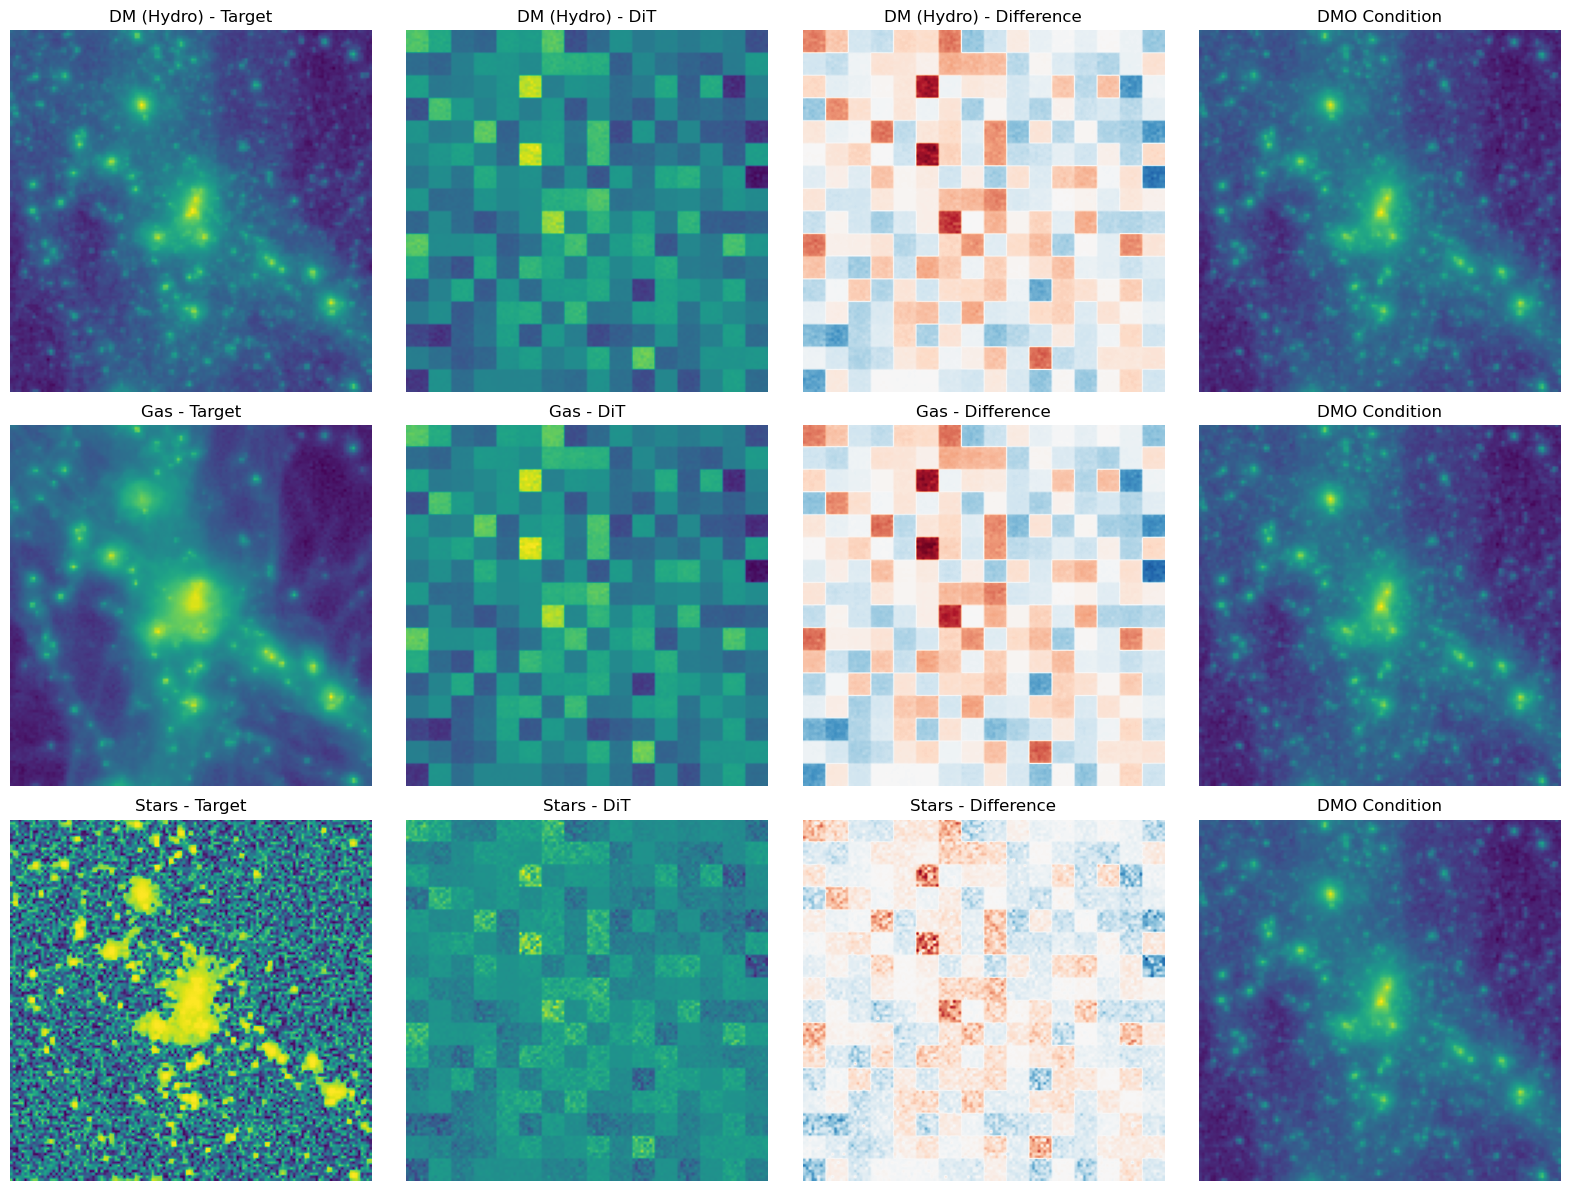

In [30]:
# Test sampling with correctly trained model
model = model.to(device).eval()

print("Testing sampling with correctly trained DiT...")
with torch.no_grad():
    sample_test = model.sample(full_conditioning[:4].to(device), param_conditioning=params[:4].to(device), n_steps=50)

print(f"Sample: min={sample_test.min():.3f}, max={sample_test.max():.3f}, std={sample_test.std():.3f}")
print(f"Target: min={target.min():.3f}, max={target.max():.3f}, std={target.std():.3f}")

# Visualize
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
channel_names = ['DM (Hydro)', 'Gas', 'Stars']

for ch in range(3):
    # Ground truth
    axes[ch, 0].imshow(target[0, ch].cpu().numpy(), cmap='viridis')
    axes[ch, 0].set_title(f'{channel_names[ch]} - Target')
    axes[ch, 0].axis('off')
    
    # Prediction
    axes[ch, 1].imshow(sample_test[0, ch].cpu().numpy(), cmap='viridis')
    axes[ch, 1].set_title(f'{channel_names[ch]} - DiT')
    axes[ch, 1].axis('off')
    
    # Difference
    diff = sample_test[0, ch].cpu().numpy() - target[0, ch].cpu().numpy()
    vmax = max(abs(diff.min()), abs(diff.max()))
    axes[ch, 2].imshow(diff, cmap='RdBu_r', vmin=-vmax, vmax=vmax)
    axes[ch, 2].set_title(f'{channel_names[ch]} - Difference')
    axes[ch, 2].axis('off')
    
    # DM Condition
    axes[ch, 3].imshow(dm_cond[0, 0].cpu().numpy(), cmap='viridis')
    axes[ch, 3].set_title('DMO Condition')
    axes[ch, 3].axis('off')

plt.tight_layout()
plt.savefig(ckpt_dir / 'dit_fixed_results.png', dpi=150)
plt.show()

In [34]:
# Test with fixed VDM-style sampling - need to recreate model with new code
import importlib
import vdm.dit_model
import vdm.dit
importlib.reload(vdm.dit)
importlib.reload(vdm.dit_model)
from vdm.dit_model import LightDiTVDM
from vdm.dit import DiT

# Create DiT backbone directly with same architecture
dit_backbone = DiT(
    img_size=128,
    patch_size=8,
    in_channels=3,
    hidden_size=256,
    depth=6,
    num_heads=4,
    mlp_ratio=4.0,
    n_params=35,
    conditioning_channels=1,
    large_scale_channels=3,
)

# Create Lightning module with the backbone
model_new = LightDiTVDM(
    dit_model=dit_backbone,  # Pass DiT instance instead of string
    gamma_min=-13.3,
    gamma_max=13.0,
    image_shape=(3, 128, 128),
)

# Load weights from checkpoint
ckpt = torch.load(ckpt_dir / 'tutorial-dit-fixed-epoch=62.ckpt', map_location=device)
model_new.load_state_dict(ckpt['state_dict'])
model_new = model_new.to(device).eval()

print("Testing with VDM-style sampling (fresh model)...")
with torch.no_grad():
    sample_vdm = model_new.sample(full_conditioning[:4].to(device), param_conditioning=params[:4].to(device), n_steps=100)

print(f"Sample: min={sample_vdm.min():.3f}, max={sample_vdm.max():.3f}, std={sample_vdm.std():.3f}")
print(f"Target: min={target.min():.3f}, max={target.max():.3f}, std={target.std():.3f}")


INITIALIZED DiT MODEL
  Image size: 128x128
  Patch size: 8
  Num patches: 256
  Hidden size: 256
  Depth: 6
  Heads: 4
  MLP ratio: 4.0
  Parameters: 35 (0=unconditional)
  Conditioning: 1 + 3 large-scale
  Total params: 7,603,392


INITIALIZED LightDiTVDM
  Learning rate: 0.0001
  Gamma range: [-13.3, 13.0]
  Sampling steps: 256
  Loss type: mse
  Image shape: (3, 128, 128)

Testing with VDM-style sampling (fresh model)...
Sample: min=-363.133, max=321.836, std=65.121
Target: min=-3.109, max=5.694, std=0.821


---
## 4. Benchmark the Model

Let's evaluate the model using standardized metrics from the `BenchmarkSuite`.

In [76]:
# Initialize benchmark suite
# BenchmarkSuite takes models dict, device, n_sampling_steps, box_size
benchmark = BenchmarkSuite(
    models={'tutorial_vdm': model},  # Add our trained model
    device=device,
    n_sampling_steps=100,
    box_size=6.25,  # Mpc/h (typical cutout size)
)

print("BenchmarkSuite initialized with metrics:")
print("  - Pixel metrics: SSIM, MAE, MSE, PSNR")
print("  - Mass metrics: integrated mass, conservation ratio")
print("  - Power spectrum: ratio, correlation")

BenchmarkSuite initialized with metrics:
  - Pixel metrics: SSIM, MAE, MSE, PSNR
  - Mass metrics: integrated mass, conservation ratio
  - Power spectrum: ratio, correlation


In [77]:
# Generate predictions for benchmark
# Use fewer steps for faster evaluation
eval_steps = min(n_steps, 100)  # Cap at 100 for speed
print(f"Generating predictions for full validation set ({eval_steps} steps)...")

all_predictions = []
all_targets = []

model.eval()
with torch.no_grad():
    for batch in val_loader:
        # Handle different data formats
        if isinstance(batch, dict):
            cond = batch['dm'].to(device)
            prms = batch['params'].to(device)
            tgt = batch['target']
            full_cond = cond  # No large_scale for synthetic
        else:
            # Real AstroDataset returns tuple: (dm, large_scale, target, params)
            dm_cond, ls, tgt, prms = batch
            dm_cond = dm_cond.to(device)
            ls = ls.to(device)
            prms = prms.to(device)
            # Concatenate dm + large_scale for conditioning
            full_cond = torch.cat([dm_cond, ls], dim=1)
        
        # Generate samples
        batch_size = full_cond.shape[0]
        pred = model.draw_samples(
            conditioning=full_cond,
            batch_size=batch_size,
            n_sampling_steps=eval_steps,
            param_conditioning=prms,
        )
        
        all_predictions.append(pred.cpu())
        all_targets.append(tgt)

predictions = torch.cat(all_predictions, dim=0)
targets = torch.cat(all_targets, dim=0)

print(f"Predictions shape: {predictions.shape}")
print(f"Targets shape: {targets.shape}")

Generating predictions for full validation set (50 steps)...
Predictions shape: torch.Size([200, 3, 128, 128])
Targets shape: torch.Size([200, 3, 128, 128])
Predictions shape: torch.Size([200, 3, 128, 128])
Targets shape: torch.Size([200, 3, 128, 128])


In [78]:
# Compute metrics manually using individual methods
# BenchmarkSuite provides per-channel metric functions

print("Benchmark Metrics Summary:")
print("=" * 50)

channel_names = ['DM', 'Gas', 'Stars']
for ch_idx, ch_name in enumerate(channel_names):
    # Get predictions and targets for this channel
    pred_ch = predictions[:, ch_idx].numpy()  # (N, H, W)
    tgt_ch = targets[:, ch_idx].numpy()
    
    # Average metrics over all samples
    ssim_vals, mae_vals, corr_vals = [], [], []
    for i in range(pred_ch.shape[0]):
        px_metrics = benchmark.compute_pixel_metrics(pred_ch[i], tgt_ch[i])
        ssim_vals.append(px_metrics.ssim)
        mae_vals.append(px_metrics.mae)
        corr_vals.append(px_metrics.correlation)
    
    print(f"\n{ch_name} Channel:")
    print(f"  SSIM: {np.mean(ssim_vals):.4f} ± {np.std(ssim_vals):.4f}")
    print(f"  MAE:  {np.mean(mae_vals):.4f} ± {np.std(mae_vals):.4f}")
    print(f"  Corr: {np.mean(corr_vals):.4f} ± {np.std(corr_vals):.4f}")

Benchmark Metrics Summary:

DM Channel:
  SSIM: 0.7437 ± 0.0428
  MAE:  0.1906 ± 0.0302
  Corr: 0.9547 ± 0.0173

DM Channel:
  SSIM: 0.7437 ± 0.0428
  MAE:  0.1906 ± 0.0302
  Corr: 0.9547 ± 0.0173

Gas Channel:
  SSIM: 0.4942 ± 0.1321
  MAE:  0.3275 ± 0.1166
  Corr: 0.9386 ± 0.0250

Gas Channel:
  SSIM: 0.4942 ± 0.1321
  MAE:  0.3275 ± 0.1166
  Corr: 0.9386 ± 0.0250

Stars Channel:
  SSIM: 0.1747 ± 0.0426
  MAE:  0.2091 ± 0.0099
  Corr: 0.4924 ± 0.0859

Stars Channel:
  SSIM: 0.1747 ± 0.0426
  MAE:  0.2091 ± 0.0099
  Corr: 0.4924 ± 0.0859


In [79]:
# Quick benchmark for a single sample using model generation
# Reload module to get fixed quick_benchmark function
import importlib
import vdm.benchmark
importlib.reload(vdm.benchmark)
from vdm.benchmark import quick_benchmark

sample_data = val_dataset[0]
dm_sample, ls_sample, target_sample, params_sample = sample_data

# Prepare conditioning
sample_cond = torch.cat([
    dm_sample.unsqueeze(0), 
    ls_sample.unsqueeze(0)
], dim=1)  # (1, 4, H, W)

# Run quick benchmark (use model-appropriate steps)
quick_steps = min(n_steps, 50)  # Cap at 50 for speed
single_metrics = quick_benchmark(
    model=model,
    conditioning=sample_cond,
    target=target_sample,
    params=params_sample.unsqueeze(0),
    n_samples=2,
    n_sampling_steps=quick_steps,
    device=device,
)

print(f"\nQuick benchmark ({MODEL_TYPE}, {quick_steps} steps, 2 realizations):")
for key, value in single_metrics.items():
    if isinstance(value, (list, np.ndarray)):
        print(f"  {key}: {[f'{v:.4f}' for v in value]}")
    else:
        print(f"  {key}: {value:.4f}")


Quick benchmark (interpolant, 50 steps, 2 realizations):
  mse: 0.1052
  correlation: 0.9299
  ssim: 0.4429
  time_mean_ms: 242.1723
  time_std_ms: 0.8893


---
## 5. Uncertainty Quantification

Generate uncertainty estimates using multiple stochastic realizations.

In [80]:
# Initialize uncertainty estimator
# UncertaintyEstimator gets device from model, no explicit device parameter
estimator = UncertaintyEstimator(
    model=model,
    n_samples=5,  # Number of stochastic realizations
    use_mc_dropout=False,  # Enable for MC Dropout uncertainty
)

print("UncertaintyEstimator initialized")
print("Methods available:")
print("  - Multi-realization sampling")
print("  - MC Dropout (if model has dropout)")
print("  - Calibration analysis")

UncertaintyEstimator initialized
Methods available:
  - Multi-realization sampling
  - MC Dropout (if model has dropout)
  - Calibration analysis


In [81]:
# Get a single sample for uncertainty analysis
test_batch = next(iter(val_loader))

# Handle different data formats
if isinstance(test_batch, dict):
    test_condition = test_batch['dm'][:1].to(device)
    test_params = test_batch['params'][:1].to(device)
    test_target = test_batch['target'][:1]
    test_full_cond = test_condition  # No large_scale for synthetic
else:
    # Real AstroDataset returns tuple: (dm, large_scale, target, params)
    dm_cond, ls, tgt, prms = test_batch
    test_condition = dm_cond[:1].to(device)  # For visualization
    test_ls = ls[:1].to(device)
    test_params = prms[:1].to(device)
    test_target = tgt[:1]
    # Full conditioning includes large_scale
    test_full_cond = torch.cat([test_condition, test_ls], dim=1)

print(f"Test full conditioning shape: {test_full_cond.shape}")

Test full conditioning shape: torch.Size([1, 4, 128, 128])


In [82]:
# Generate multiple realizations for uncertainty
N_REALIZATIONS = 10  # Reduced for tutorial speed
uncertainty_steps = min(n_steps, 100)  # Use model-appropriate steps

print(f"Generating {N_REALIZATIONS} realizations with {MODEL_TYPE} ({uncertainty_steps} steps)...")

# Create estimator with desired number of samples
estimator = UncertaintyEstimator(model, n_samples=N_REALIZATIONS)

# Use predict_with_uncertainty
result = estimator.predict_with_uncertainty(
    conditioning=test_full_cond,
    params=test_params,
    n_sampling_steps=uncertainty_steps,
    show_progress=True,
)

# Extract mean and std (numpy arrays)
mean = result.mean
std = result.std

print(f"Mean shape: {mean.shape}")
print(f"Std shape: {std.shape}")

Generating 10 realizations with interpolant (50 steps)...


Sampling for uncertainty: 100%|██████████| 10/10 [00:02<00:00,  4.13it/s]

Mean shape: (1, 3, 128, 128)
Std shape: (1, 3, 128, 128)


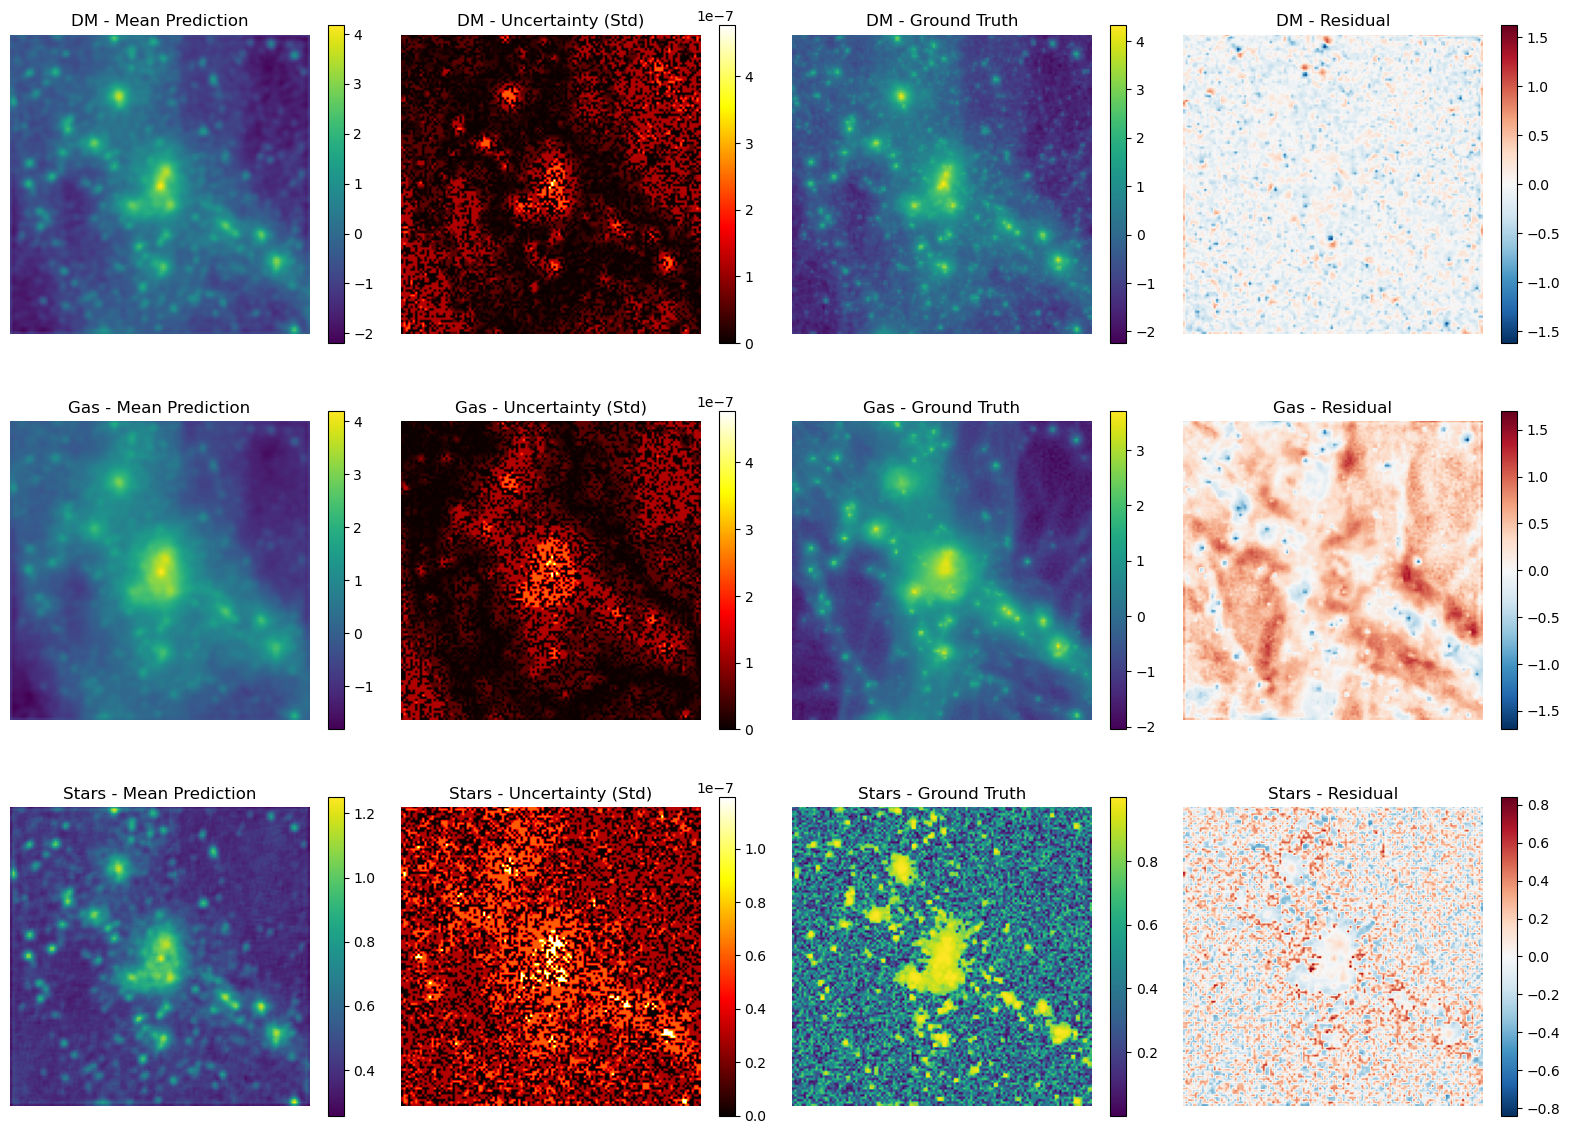

In [83]:
# Visualize uncertainty maps
# mean and std are already numpy arrays from UncertaintyResult
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
channel_names = ['DM', 'Gas', 'Stars']

for ch_idx, ch_name in enumerate(channel_names):
    # Mean prediction
    im1 = axes[ch_idx, 0].imshow(mean[0, ch_idx], cmap='viridis')
    axes[ch_idx, 0].set_title(f'{ch_name} - Mean Prediction')
    plt.colorbar(im1, ax=axes[ch_idx, 0], shrink=0.8)
    
    # Uncertainty (std)
    im2 = axes[ch_idx, 1].imshow(std[0, ch_idx], cmap='hot')
    axes[ch_idx, 1].set_title(f'{ch_name} - Uncertainty (Std)')
    plt.colorbar(im2, ax=axes[ch_idx, 1], shrink=0.8)
    
    # Ground truth
    im3 = axes[ch_idx, 2].imshow(test_target[0, ch_idx].numpy(), cmap='viridis')
    axes[ch_idx, 2].set_title(f'{ch_name} - Ground Truth')
    plt.colorbar(im3, ax=axes[ch_idx, 2], shrink=0.8)
    
    # Residual
    residual = mean[0, ch_idx] - test_target[0, ch_idx].numpy()
    vmax = np.abs(residual).max()
    im4 = axes[ch_idx, 3].imshow(residual, cmap='RdBu_r', vmin=-vmax, vmax=vmax)
    axes[ch_idx, 3].set_title(f'{ch_name} - Residual')
    plt.colorbar(im4, ax=axes[ch_idx, 3], shrink=0.8)

for ax in axes.flat:
    ax.axis('off')

plt.tight_layout()
plt.savefig('uncertainty_maps.png', dpi=150, bbox_inches='tight')
plt.show()

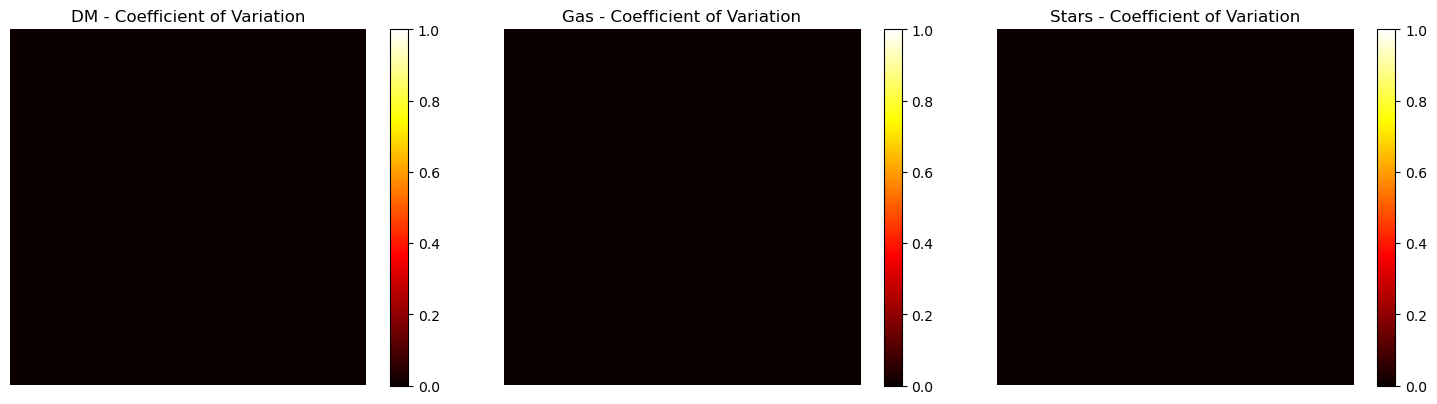

In [84]:
# Compute coefficient of variation (relative uncertainty)
# Note: mean and std are numpy arrays, not tensors
cv = std / (np.abs(mean) + 1e-8)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
channel_names = ['DM', 'Gas', 'Stars']

for i, name in enumerate(channel_names):
    im = axes[i].imshow(cv[0, i], cmap='hot', vmin=0, vmax=1)
    axes[i].set_title(f'{name} - Coefficient of Variation')
    axes[i].axis('off')
    plt.colorbar(im, ax=axes[i])

plt.tight_layout()
plt.savefig('coefficient_of_variation.png', dpi=150, bbox_inches='tight')
plt.show()

In [85]:
# Analyze uncertainty statistics
# Note: std and cv are numpy arrays
print("\nUncertainty Statistics:")
for i, name in enumerate(channel_names):
    channel_std = std[0, i]
    channel_cv = cv[0, i]
    print(f"\n{name}:")
    print(f"  Std - mean: {channel_std.mean():.4f}, max: {channel_std.max():.4f}")
    print(f"  CV  - mean: {channel_cv.mean():.4f}, max: {channel_cv.max():.4f}")


Uncertainty Statistics:

DM:
  Std - mean: 0.0000, max: 0.0000
  CV  - mean: 0.0000, max: 0.0000

Gas:
  Std - mean: 0.0000, max: 0.0000
  CV  - mean: 0.0000, max: 0.0000

Stars:
  Std - mean: 0.0000, max: 0.0000
  CV  - mean: 0.0000, max: 0.0000


---
## 6. Model Comparison & Ensembles

In practice, you would train multiple models and compare them. Here we demonstrate the ensemble API.

In [86]:
# For demonstration, we'll create a simple ensemble with copies of our model
# In practice, you would load different trained models

print("Creating demonstration ensemble...")
print("(In practice, use models trained with different seeds/architectures)")

# Simple ensemble with single model (for API demonstration)
ensemble = ModelEnsemble([model])

print(f"\nEnsemble with {len(ensemble.models)} model(s)")

Creating demonstration ensemble...
(In practice, use models trained with different seeds/architectures)

Ensemble with 1 model(s)


In [87]:
# Generate ensemble prediction
ensemble_steps = min(n_steps, 100)
print(f"\nGenerating ensemble prediction ({ensemble_steps} steps)...")

with torch.no_grad():
    ensemble_pred = ensemble.draw_samples(
        conditioning=test_full_cond,
        batch_size=1,
        n_sampling_steps=ensemble_steps,
        param_conditioning=test_params,
    )

print(f"Ensemble prediction shape: {ensemble_pred.shape}")


Generating ensemble prediction (50 steps)...
Ensemble prediction shape: torch.Size([1, 3, 128, 128])
Ensemble prediction shape: torch.Size([1, 3, 128, 128])


In [88]:
# Compare single model vs ensemble using compute_pixel_metrics
print("\nComparison: Single Model vs Ensemble")
print("(Note: With only one model in ensemble, results will be similar)")

# Compute pixel metrics directly (not using quick_benchmark which needs model)
single_pred = mean[0]  # numpy (3, H, W)
ensemble_pred_np = ensemble_pred[0].cpu().numpy()  # (3, H, W)
target_np = test_target[0].numpy()  # (3, H, W)

print("\nChannel-wise SSIM comparison:")
print("Channel | Single Model | Ensemble")
print("-" * 40)

for ch_idx, ch_name in enumerate(channel_names):
    single_px = benchmark.compute_pixel_metrics(single_pred[ch_idx], target_np[ch_idx])
    ens_px = benchmark.compute_pixel_metrics(ensemble_pred_np[ch_idx], target_np[ch_idx])
    print(f"{ch_name:7} | {single_px.ssim:12.4f} | {ens_px.ssim:.4f}")


Comparison: Single Model vs Ensemble
(Note: With only one model in ensemble, results will be similar)

Channel-wise SSIM comparison:
Channel | Single Model | Ensemble
----------------------------------------
DM      |       0.7512 | 0.7512
Gas     |       0.4219 | 0.4219
Stars   |       0.1494 | 0.1494


---
## Summary

In this tutorial, you learned how to:

1. ✅ **Load and explore** training data from CAMELS simulations
2. ✅ **Train a generative model** using PyTorch Lightning (VDM, DSM, Flow Matching, etc.)
3. ✅ **Generate baryonic fields** from DMO conditions
4. ✅ **Benchmark** with SSIM, power spectrum, and mass metrics
5. ✅ **Quantify uncertainty** using multiple realizations
6. ✅ **Compare models** using the ensemble framework

### Available Model Types

| Model | Description | Sampling Speed |
|-------|-------------|----------------|
| `vdm` | Variational Diffusion Model | ~250 steps |
| `dsm` | Denoising Score Matching | ~250 steps |
| `interpolant` | Flow Matching (deterministic) | ~50 steps ⚡ |
| `stochastic_interpolant` | Stochastic Flow Matching | ~50 steps ⚡ |
| `ot_flow` | Optimal Transport Flow | ~50 steps ⚡ |
| `consistency` | Consistency Model | ~2 steps 🚀 |

To try a different model, change `MODEL_TYPE` in cell 5!

### Next Steps

- **Train on full data**: Use all training samples for better results
- **Compare models**: Try different `MODEL_TYPE` values and compare metrics
- **Apply BIND**: Use `bind_predict.py` on your simulations
- **Explore analysis notebooks**: See `analysis/notebooks/` for more examples

### Resources

- [README.md](../../README.md) - Full documentation
- [Model Comparison](../../vdm/MODEL_COMPARISON.md) - Model architecture details
- [BIND Workflow](01_bind_overview.ipynb) - Full BIND pipeline

In [59]:
# Cleanup - remove tutorial checkpoints if desired
# import shutil
# shutil.rmtree(ckpt_dir)
# print("Tutorial checkpoints removed")